In [1]:
import ROOT
import uproot
import math
import psutil,time
from tqdm import tqdm
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from concurrent.futures import ThreadPoolExecutor
import event_selection
import ReadRoot
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.nn import DynamicEdgeConv, global_max_pool,global_mean_pool,knn_graph,MessagePassing
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_scatter import scatter_max, scatter_mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
random_state = 42
BatchSize = 4096
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

In [ ]:
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
CellSize=5.0  # mm
SamplingLayer=30
ECAL_layers=120
Layer_thickness=5.05  # mm
Threshold=Threshold_i*MIP_table[Si]

def ReadData_Energy(DataPath, ParticleEnergy, precision=0.01):
    Events_all = []
    for energy_val in ParticleEnergy:
        input_file_name = f"{DataPath}/{energy_val}GeV.root"
        print(f"Reading file: {input_file_name}")
        Events = ReadRoot.read_root(input_file_name, threshold=Threshold)
        Events_all.extend(Events)
    return Events_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    Events_all = []
    for input_file in root_files:
        print(f"Reading file: {input_file}")
        Events = ReadRoot.read_root(input_file, threshold=Threshold)
        Events_all.extend(Events)
    return Events_all
# def ReadRoot(input_file_name):
#     print(f"Processing file: {input_file_name}")
#     input_file = uproot.open(input_file_name)
#     tree = input_file["events"]
#     energy = tree["simplecaloRO.energy"].array(library="ak")
#     pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
#     pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
#     pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
#     E_truth = tree["MCParticles.p0"].array(library="ak")
#     threshold_mask = energy * 1000 > Threshold
#     energy = energy[threshold_mask]
#     pos_x = pos_x[threshold_mask]
#     pos_y = pos_y[threshold_mask]
#     pos_z = pos_z[threshold_mask]
#     return energy, pos_x, pos_y, pos_z, E_truth
#Read Data
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
Events_test = ReadData_Energy(DataPath_Validate,Energy_test)
Events_uniform = ReadData_Uniform(DataPath_Uniform)

Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/0.1GeV.root
Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/0.25GeV.root
Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/0.5GeV.root
Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/1.0GeV.root
Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/2.0GeV.root
Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/5.0GeV.root
Reading file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/10.

shapes: (59981,) (23254394,) (23254394,) (23254394,)


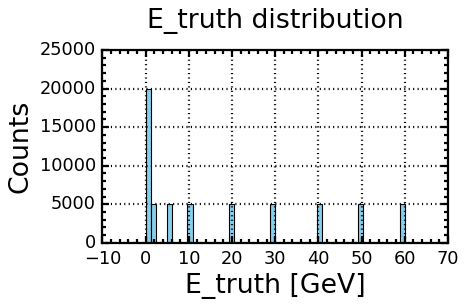

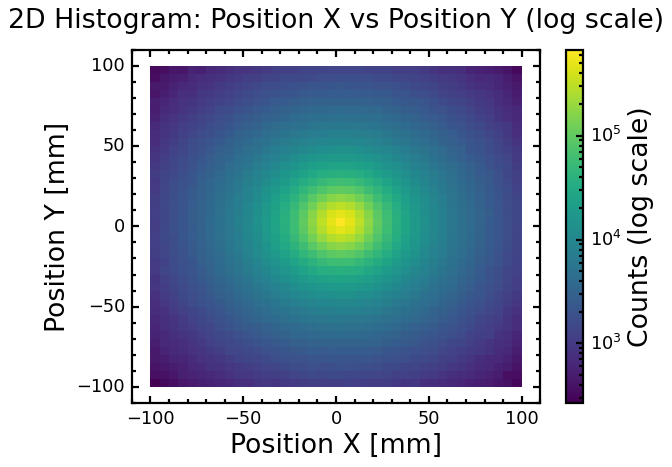

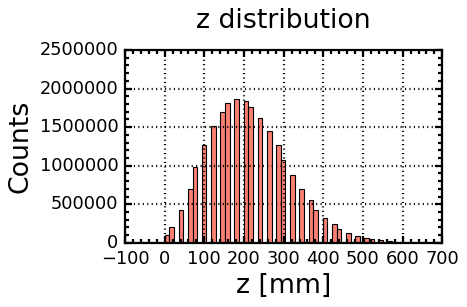

In [ ]:
events = Events_test

# E_truth (每个事件一个值)
E_truth = np.array([ev.E_truth for ev in events])

# x, y, z (flatten 所有 hits)
x = np.array([pos for ev in events for pos in ev.pos_x])
y = np.array([pos for ev in events for pos in ev.pos_y])
z = np.array([pos for ev in events for pos in ev.pos_z])

print("shapes:", E_truth.shape, x.shape, y.shape, z.shape)

import matplotlib.pyplot as plt

# --------------------------
# E_truth histogram
plt.figure(figsize=(6,4))
plt.hist(E_truth, bins=50, color='skyblue')
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.title("E_truth distribution")
plt.tight_layout()
plt.show()

# --------------------------
# 2D histogram: PosX vs PosY
plt.figure(figsize=fig_size)
plt.hist2d(x, y, bins=[int(220/CellSize), int(220/CellSize)], range=[[-110, 110], [-110, 110]], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Counts (log scale)')
plt.xlabel("Position X [mm]")
plt.ylabel("Position Y [mm]")
plt.title("2D Histogram: Position X vs Position Y (log scale)")
plt.grid(False)
plt.tight_layout()
plt.show()
# --------------------------
# z histogram
plt.figure(figsize=(6,4))
plt.hist(z, bins=50, color='salmon')
plt.xlabel("z [mm]")
plt.ylabel("Counts")
plt.title("z distribution")
plt.tight_layout()
plt.show()


In [ ]:
def make_event_graph_from_ak(Events, extra_features=None, k=3,n_events=0):
    data_list = []
    for i in tqdm(range(n_events), desc="Building event graphs"):
        conv_feat = torch.tensor(np.array(Events[i].energy), dtype=torch.float32).unsqueeze(-1)
        pos_np = np.column_stack([np.array(Events[i].pos_x), np.array(Events[i].pos_y), np.array(Events[i].pos_z)])
        pos = torch.tensor(pos_np, dtype=torch.float32)
        x = torch.cat([conv_feat, pos], dim=-1)  # (n_nodes, conv_dim+pos_dim)
        y = torch.tensor([Events[i].E_truth], dtype=torch.float32)
        edge_index = knn_graph(pos, k=k, loop=False)
        # Extra event-level features
        extra = None
        if extra_features is not None:
            ef = extra_features[i]
            if not isinstance(ef, torch.Tensor):
                ef = torch.tensor(ef, dtype=torch.float32)
            extra = ef.unsqueeze(0)  # shape (1, extra_dim)
        # Build Data object
        data = Data(
            x=x,
            edge_index=edge_index,
            y=y,
            extra=extra
        )
        data_list.append(data)
    return data_list
KNN_K = 16
data_list_uniform = make_event_graph_from_ak(Events_uniform, k=KNN_K, n_events=len(Events_uniform))
data_list_test  = make_event_graph_from_ak(Events_test, k=KNN_K, n_events=len(Events_test))


Building event graphs: 100%|██████████| 59981/59981 [01:39<00:00, 600.35it/s] 


In [ ]:
val_split = 0.2
data_list_train, data_list_val = train_test_split(data_list_uniform, test_size=val_split, random_state=random_state)


In [ ]:
class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #base = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #loss = base * (1 + abs_rel)
        #loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, 0.5 * (abs_rel - self.delta + self.delta**2))
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        return torch.mean(loss)
class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = x
        #out = self.activation(out)
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out
    
#General MLP with residual blocks, no need for input dim
class MLPRegressor(nn.Module):
    def __init__(self, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.inferred_input_dim = None
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        layers.append(nn.Sequential(
            nn.LazyBatchNorm1d(),
            nn.LazyLinear(hidden_dims[0]),
            activation,
            nn.Dropout(dropout)
        ))
        prev_dim = hidden_dims[0]
        for h in hidden_dims[1:]:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h

        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)  # 输出事件预测

    def forward(self, x):
        if self.inferred_input_dim is None:
            self.inferred_input_dim = x.shape[-1]
            print(f"MLP input dim: {self.inferred_input_dim}")
        x = self.model(x)
        # return self.output_layer(x).squeeze(-1)
        return x

class EdgeConv(nn.Module):
    def __init__(self, hidden_layers=[32,32,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.mlp = MLPRegressor(hidden_dims=hidden_layers, dropout=dropout, activation=activation)
    def forward(self, x, edge_index):
        row, col = edge_index
        x_i, x_j = x[row], x[col]
        edge_feat = torch.cat([x_i, x_j - x_i], dim=-1)
        out = self.mlp(edge_feat)
        #out,_ = scatter_max(out, row, dim=0, dim_size=x.size(0))
        out = scatter_mean(out, row, dim=0, dim_size=x.size(0))
        return out

class DGCNN_MLP(nn.Module):
    def __init__(self, EdgeMLP_hidden=[[128,128],[64,64]], mlp_hidden=[128,64,32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        self.edge_convs = nn.ModuleList()
        for hidden in EdgeMLP_hidden:
            self.edge_convs.append(
                EdgeConv(hidden_layers=hidden, dropout=dropout, activation=activation)
            )
        print(f"Edge MLP hidden dims per layer: {EdgeMLP_hidden}, Dropout: {dropout}, Activation: {activation}")

        print(f"MLP hidden dims: {mlp_hidden}, Dropout: {dropout}, Activation: {activation}")
        self.mlp = MLPRegressor(hidden_dims=mlp_hidden, dropout=dropout, activation=activation)
        print(f"Output layer: Linear({mlp_hidden[-1]} -> 1)")
        self.energy_output_layer = nn.Linear(mlp_hidden[-1], 1)

    def forward(self, data):
        x = data.x
        for conv in self.edge_convs:
            x = conv(x, data.edge_index)
        x = global_mean_pool(x, data.batch)
        if hasattr(data, 'extra') and data.extra is not None:
            combined = torch.cat([x, data.extra], dim=-1)
        else:
            combined = x
        out = self.mlp(combined)
        out = self.energy_output_layer(out).squeeze(-1)
        return out




In [ ]:
def train_dgcnn(data_list_train,data_list_val,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
            EdgeMLP_dims=[64, 128],
              mlp_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=30,
              patience=10,
              val_split=0.2,
              random_state=42,
              model_name="DGCNN_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(data_list_train)}, Validation samples: {int(len(data_list_val))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    train_loader = PyGDataLoader(data_list_train, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(data_list_val, batch_size=batch_size, shuffle=False)

    # Model
    model = DGCNN_MLP(
        EdgeMLP_hidden=EdgeMLP_dims,
        mlp_hidden=mlp_dims,
        dropout=dropout,
        activation=activation
    ).to(device)
    
    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch <= warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = (epochs/50) * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, batch.y)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred = model(batch)
                loss = criterion(pred, batch.y)
                val_loss += loss.item() * batch.num_graphs

        train_loss /= len(train_loader.dataset)
        val_loss   /= len(val_loader.dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}｜ patience: {patience_counter}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            if (best_val_loss - val_loss) / best_val_loss > 0.01:
                patience_counter = 0
            best_val_loss = val_loss
            best_state_dict = model.state_dict()    
            torch.save(model, model_name)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    model.eval()
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch)
            y_val_true.append(batch.y.cpu())
            y_val_pred.append(pred.cpu())
    y_val_true = torch.cat(y_val_true, dim=0).numpy()
    y_val_pred = torch.cat(y_val_pred, dim=0).numpy()
    return model,y_val_true, y_val_pred,best_val_loss

Using device: cuda
Random state: 42
Training samples: 99972, Validation samples: 24993
learning rate: 0.0005, batch size: 256, epochs: 30, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [32, 32, 32], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [64, 64, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Edge MLP hidden dims per layer: [[32, 32, 32], [64, 64, 64]], Dropout: 0.1, Activation: PReLU(num_parameters=1)
MLP hidden dims: [256, 128, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Hidden dims: [256, 128, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Output layer: Linear(64 -> 1)
MLP input dim: 8
MLP input dim: 64
MLP input dim: 64
Epoch 001/30 | Train Loss: 0.047897 | Val Loss: 0.046690| LR: 0.000200｜ patience: 0
Epoch 002/30 | Train Loss: 0.042532 | Val Loss: 0.031230| LR: 0.000300｜ patience: 0
Epoch 003/30 | Train Loss: 0.017612 | Val Loss: 0.006441| LR: 0.000400｜ patience: 0
Epoch 004/30 | Train Loss: 0.008501 | Val Loss: 0.

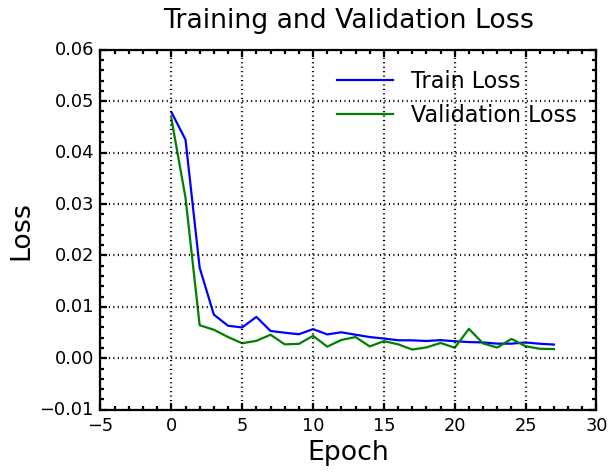

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
CONF_NAME="1.0Data"
model_name = DataPath_Validate+f"/Models/{CONF_NAME}.pth"
dgcnn_model, y_val_true, y_val_pred, best_val_loss = train_dgcnn(
    data_list_train,
    data_list_val,
    activation=nn.PReLU(),
    loss=HuberRelativeLoss(delta=0.05),
    EdgeMLP_dims=[[32,32,32],[64,64,64]],
    mlp_dims=[256, 128, 64],
    dropout=0.1,
    lr=5e-4,
    weight_decay=1e-8,
    batch_size=256,
    epochs=30,
    patience=10,
    val_split=0.2,
    random_state=random_state,
    model_name=model_name
)
# Evaluate on test set

In [ ]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (0.1, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = ( np.isclose(y_truth, E_truth) )
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

Reco_hist_all = []

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
device = next(dgcnn_model.parameters()).device
dgcnn_model.eval()
test_loader = PyGDataLoader(data_list_test, batch_size=256, shuffle=False)
y_test_true, y_test_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = dgcnn_model(batch)
        y_test_true.append(batch.y.cpu())
        y_test_pred.append(pred.cpu())
y_test_true = torch.cat(y_test_true, dim=0).numpy()
y_test_pred = torch.cat(y_test_pred, dim=0).numpy()

Reco_hist_all.clear()
Reco_hist = build_reco_hist(y_test_pred, y_test_true, Energy_test, Nbins=50)
Reco_hist_all.append(Reco_hist)

# fit_range = (0, 65) 
# mask = y_val_pred>0
# residual_E = (y_val_pred[mask] - y_val_true[mask]) / y_val_pred[mask]
# E_calib_fit = Combined_fit(y_val_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=200)
# x_fit = np.linspace(fit_range[0], fit_range[1], 200)
# y_fit = E_calib_fit(x_fit)
# plt.figure(figsize=fig_size)
# plot_binned(y_val_pred[mask], residual_E, num_bins=200, color="blue", label="Validate samples")
# #plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
# plt.plot(x_fit, y_fit, color='red', label='Fit')
# plt.xlabel("E_pred [GeV]")
# plt.ylabel("(E_pred - E_true)/E_pred")
# plt.title("Residual vs E_pred")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="lower right")
# plt.show()

# y_val_pred_calib = y_val_pred*(1-E_calib_fit(y_val_pred))
# y_test_pred_calib = y_test_pred*(1-E_calib_fit(y_test_pred))
# Reco_hist_all.clear()
# Reco_hist = build_reco_hist(y_test_pred_calib, y_test_true, Energy_test, Nbins=100)
# Reco_hist_all.append(Reco_hist)

# plt.figure(figsize=fig_size)
# plot_binned(y_test_true, y_test_pred, color="blue", label="test samples")
# plot_binned(y_val_true, y_val_pred, color="green", label="validate samples")
# plt.xlabel("E_truth [GeV]")
# plt.ylabel("E_pred [GeV]")
# plt.title("MLP Reconstructed Energy vs True Energy")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="upper left")  
# plt.show()


In [ ]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


length of Reco_hist_all: 1
length of Reco_hist: 12
Mean: 10.002268237273853, Peak: 10.059529304504395, RMS: 0.7093529493279407
Initial Gamma Fit Parameters: [np.float64(574.6806764602661), np.float64(3.7284987244324546), np.float32(7.3574467), np.float64(0.7093529493279407)]
Gamma Fit Bounds: lower [np.float64(5.7468067646026615), np.float64(-0.6271501275567546), np.float32(-0.26425534), np.float64(0.07093529493279407)], 
 upper [np.float64(3448.0840587615967), np.float64(37.28498724432455), np.float32(21.036171), np.float64(7.093529493279407)]
Gamma Fit Parameters: [5.72907808e+02 3.72849872e+01 5.73903869e+00 1.15012890e-01]
Gamma Fit Peak: 9.912279934126008 ± 0.015043793001065989, Mean: 10.027292824008459 ± 0.01520954674572269, Resolution: 0.07085001668156266 ± 0.0010783653052799204


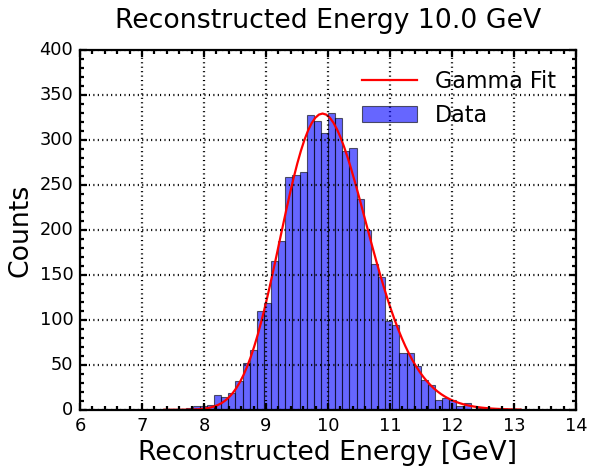

In [ ]:
#This cell is left here for debug
print("length of Reco_hist_all:", len(Reco_hist_all))
Reco_hist = Reco_hist_all[0] # Example for first beta
print("length of Reco_hist:", len(Reco_hist))
i_E = 6 # Example index, change as needed
#print(len(Reco_hist))
#print(Reco_hist[i_E])
mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
    "E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])

Saving fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Reco_Results/RecoE_DGCNN_[256]_WD1e-8_Fit.csv
Mean: 0.1961710507420741, Peak: 0.11335352063179016, RMS: 0.1579588992768222
Initial Gamma Fit Parameters: [np.float64(384.70938232541084), np.float64(1.257735945237245), np.float32(-0.0024995347), np.float64(0.1579588992768222)]
Gamma Fit Bounds: lower [np.float64(3.8470938232541085), np.float64(-0.8742264054762755), np.float32(-1.00025), np.float64(0.01579588992768222)], 
 upper [np.float64(2308.256293952465), np.float64(12.57735945237245), np.float32(9.996251), np.float64(1.5795889927682218)]
Gamma Fit Parameters: [ 3.92848486e+02  4.85106867e+00 -4.72047157e-02  5.04822203e-02]
Gamma Fit Peak: 0.1472057816721704 ± 0.004906948269410843, Mean: 0.19768800200746187 ± 0.004946579653718623, Resolution: 0.7553222734554011 ± 0.04904495126634029


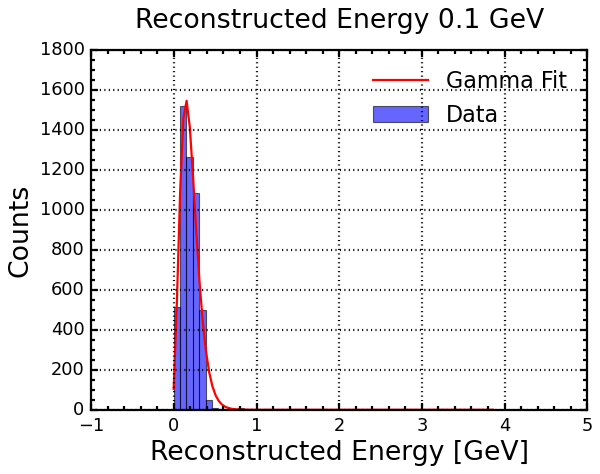

appending results for E = 0.1
Mean_Gamma: 0.19768800200746187 Mean_Gamma_Error: 0.004946579653718623
Peak_Gamma: 0.1472057816721704 Peak_Gamma_Error: 0.004906948269410843
Mean: 0.33379591720792146, Peak: 0.32285991311073303, RMS: 0.09904141887817713
Initial Gamma Fit Parameters: [np.float64(270.4198921099305), np.float64(3.116833568001922), np.float32(0.025100298), np.float64(0.09904141887817713)]
Gamma Fit Bounds: lower [np.float64(2.704198921099305), np.float64(-0.6883166431998078), np.float32(-0.99749), np.float64(0.009904141887817713)], 
 upper [np.float64(1622.519352659583), np.float64(31.168335680019222), np.float32(10.03765), np.float64(0.9904141887817713)]
Gamma Fit Parameters: [2.53767034e+02 3.11683357e+01 3.73090942e-02 9.90414189e-03]
Gamma Fit Peak: 0.33610057131296966 ± 0.0034403828628840664, Mean: 0.3460047132027378 ± 0.0033743369471664893, Resolution: 0.1645145860685016 ± 0.007448752203770459


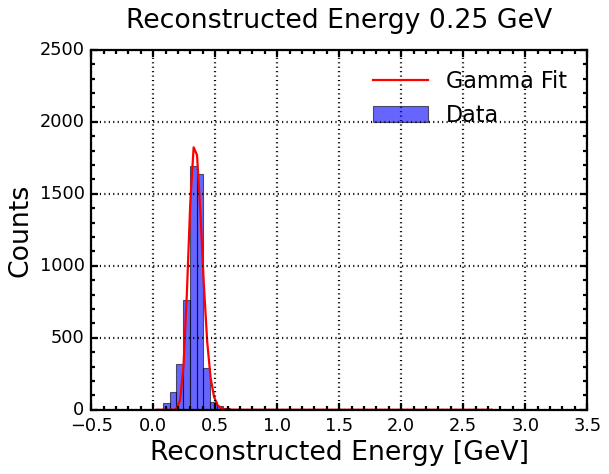

appending results for E = 0.25
Mean_Gamma: 0.3460047132027378 Mean_Gamma_Error: 0.0033743369471664893
Peak_Gamma: 0.33610057131296966 Peak_Gamma_Error: 0.0034403828628840664
Mean: 0.5253409383558386, Peak: 0.37899577617645264, RMS: 0.13416079965322414
Initial Gamma Fit Parameters: [np.float64(120.98735366761684), np.float64(3.891466756604518), np.float32(0.0032586465), np.float64(0.13416079965322414)]
Gamma Fit Bounds: lower [np.float64(1.2098735366761684), np.float64(-0.6108533243395482), np.float32(-0.99967414), np.float64(0.013416079965322415)], 
 upper [np.float64(725.9241220057011), np.float64(38.91466756604518), np.float32(10.004888), np.float64(1.3416079965322414)]
Gamma Fit Parameters: [ 1.25540390e+02  1.99421003e+01 -1.39889271e-01  3.35758833e-02]
Gamma Fit Peak: 0.4961084765745785 ± 0.011900013913033953, Mean: 0.5296843598567536 ± 0.012150521218251095, Resolution: 0.3022290782960853 ± 0.02105279034466723


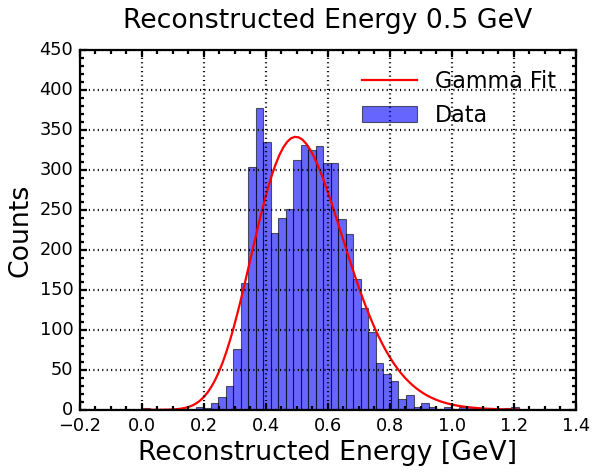

appending results for E = 0.5
Mean_Gamma: 0.5296843598567536 Mean_Gamma_Error: 0.012150521218251095
Peak_Gamma: 0.4961084765745785 Peak_Gamma_Error: 0.011900013913033953
Mean: 0.9079863877773953, Peak: 0.8253625631332397, RMS: 0.17426037056004345
Initial Gamma Fit Parameters: [np.float64(149.2043319940567), np.float64(3.643403381744268), np.float32(0.27308556), np.float64(0.17426037056004345)]
Gamma Fit Bounds: lower [np.float64(1.492043319940567), np.float64(-0.6356596618255732), np.float32(-0.9726914), np.float64(0.017426037056004345)], 
 upper [np.float64(895.2259919643402), np.float64(36.43403381744268), np.float32(10.409628), np.float64(1.7426037056004344)]
Gamma Fit Parameters: [1.45469120e+02 4.04648170e+00 5.82231918e-01 7.94351177e-02]
Gamma Fit Peak: 0.8242295504461197 ± 0.003103939201696862, Mean: 0.9036646681795593 ± 0.003499166483704612, Resolution: 0.19386667113324318 ± 0.004436189548075868


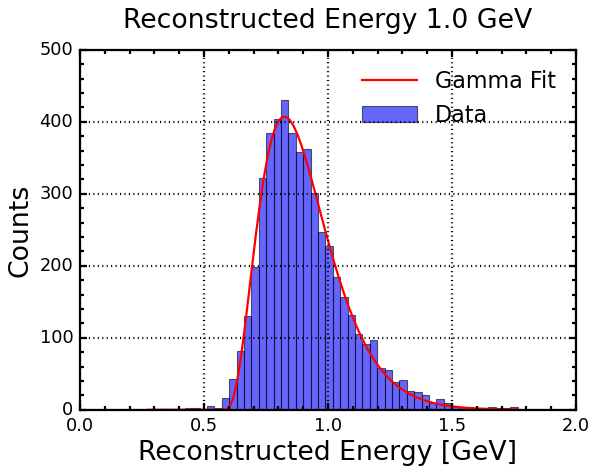

appending results for E = 1.0
Mean_Gamma: 0.9036646681795593 Mean_Gamma_Error: 0.003499166483704612
Peak_Gamma: 0.8242295504461197 Peak_Gamma_Error: 0.003103939201696862
Mean: 1.9202445179110743, Peak: 1.8227720260620117, RMS: 0.2737952321509197
Initial Gamma Fit Parameters: [np.float64(213.5952204465866), np.float64(3.555168112865137), np.float32(0.94685644), np.float64(0.2737952321509197)]
Gamma Fit Bounds: lower [np.float64(2.135952204465866), np.float64(-0.6444831887134863), np.float32(-0.9053143), np.float64(0.027379523215091975)], 
 upper [np.float64(1281.5713226795197), np.float64(35.55168112865137), np.float32(11.420284), np.float64(2.737952321509197)]
Gamma Fit Parameters: [2.11518591e+02 3.55516811e+01 3.44976154e-01 4.47681930e-02]
Gamma Fit Peak: 1.8917924842552545 ± 0.006717397856762883, Mean: 1.9365606772883526 ± 0.006795385942573625, Resolution: 0.1410997163344676 ± 0.002627529505241166


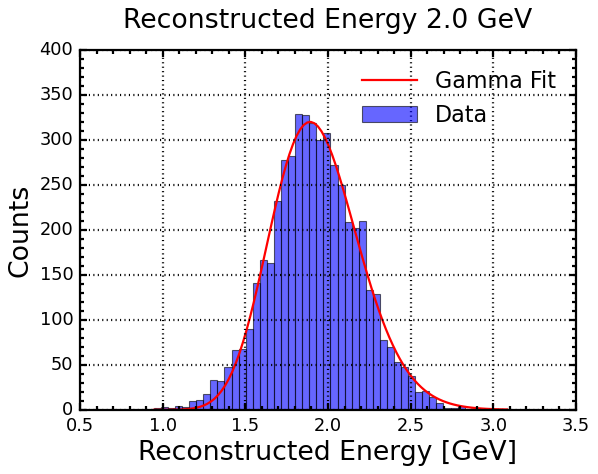

appending results for E = 2.0
Mean_Gamma: 1.9365606772883526 Mean_Gamma_Error: 0.006795385942573625
Peak_Gamma: 1.8917924842552545 Peak_Gamma_Error: 0.006717397856762883
Mean: 4.824224199240483, Peak: 4.83401346206665, RMS: 0.48697319588771637
Initial Gamma Fit Parameters: [np.float64(418.89751744270325), np.float64(4.711980250946182), np.float32(2.529616), np.float64(0.48697319588771637)]
Gamma Fit Bounds: lower [np.float64(4.188975174427033), np.float64(-0.5288019749053818), np.float32(-0.74703836), np.float64(0.04869731958877164)], 
 upper [np.float64(2513.3851046562195), np.float64(47.11980250946182), np.float32(13.794424), np.float64(4.869731958877164)]
Gamma Fit Parameters: [4.19609108e+02 4.71198025e+01 1.48892501e+00 7.10890286e-02]
Gamma Fit Peak: 4.767536966951907 ± 0.008040522451910849, Mean: 4.8386259955927065 ± 0.008111521371326312, Resolution: 0.1023552778740559 ± 0.0011936078567808582


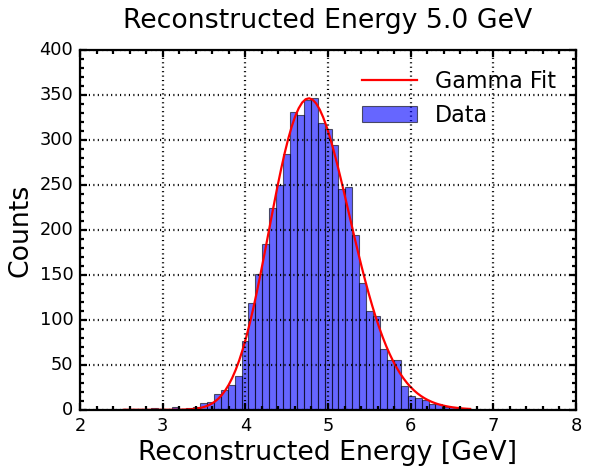

appending results for E = 5.0
Mean_Gamma: 4.8386259955927065 Mean_Gamma_Error: 0.008111521371326312
Peak_Gamma: 4.767536966951907 Peak_Gamma_Error: 0.008040522451910849
Mean: 10.002268237273853, Peak: 10.059529304504395, RMS: 0.7093529493279407
Initial Gamma Fit Parameters: [np.float64(574.6806764602661), np.float64(3.7284987244324546), np.float32(7.3574467), np.float64(0.7093529493279407)]
Gamma Fit Bounds: lower [np.float64(5.7468067646026615), np.float64(-0.6271501275567546), np.float32(-0.26425534), np.float64(0.07093529493279407)], 
 upper [np.float64(3448.0840587615967), np.float64(37.28498724432455), np.float32(21.036171), np.float64(7.093529493279407)]
Gamma Fit Parameters: [5.72907808e+02 3.72849872e+01 5.73903869e+00 1.15012890e-01]
Gamma Fit Peak: 9.912279934126008 ± 0.015043793001065989, Mean: 10.027292824008459 ± 0.01520954674572269, Resolution: 0.07085001668156266 ± 0.0010783653052799204


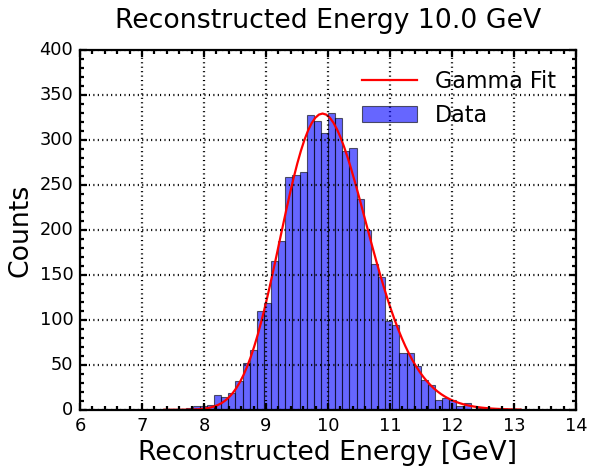

appending results for E = 10.0
Mean_Gamma: 10.027292824008459 Mean_Gamma_Error: 0.01520954674572269
Peak_Gamma: 9.912279934126008 Peak_Gamma_Error: 0.015043793001065989
Mean: 20.615283769029038, Peak: 20.497047424316406, RMS: 1.0164711238192452
Initial Gamma Fit Parameters: [np.float64(802.7243041992188), np.float64(3.515503634150539), np.float32(17.041876), np.float64(1.0164711238192452)]
Gamma Fit Bounds: lower [np.float64(8.027243041992188), np.float64(-0.6484496365849461), np.float32(0.70418763), np.float64(0.10164711238192453)], 
 upper [np.float64(4816.3458251953125), np.float64(35.155036341505394), np.float32(35.562813), np.float64(10.164711238192453)]
Gamma Fit Parameters: [8.00460053e+02 3.51550363e+01 1.46464691e+01 1.71048896e-01]
Gamma Fit Peak: 20.488650355308433 ± 0.02394040189781866, Mean: 20.65969925145171 ± 0.024220540004317448, Resolution: 0.04949948725637361 ± 0.0008266202605210841


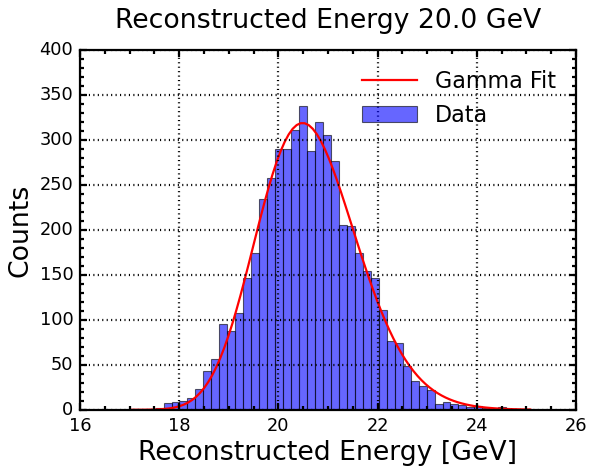

appending results for E = 20.0
Mean_Gamma: 20.65969925145171 Mean_Gamma_Error: 0.024220540004317448
Peak_Gamma: 20.488650355308433 Peak_Gamma_Error: 0.02394040189781866
Mean: 31.006703928897256, Peak: 30.668434143066406, RMS: 1.213173990473323
Initial Gamma Fit Parameters: [np.float64(985.3741493225098), np.float64(4.098591739808504), np.float32(26.034399), np.float64(1.213173990473323)]
Gamma Fit Bounds: lower [np.float64(9.853741493225098), np.float64(-0.5901408260191496), np.float32(1.60344), np.float64(0.1213173990473323)], 
 upper [np.float64(5912.244895935059), np.float64(40.98591739808504), np.float32(49.051598), np.float64(12.13173990473323)]
Gamma Fit Parameters: [9.83723104e+02 4.09859174e+01 2.33557340e+01 1.88465438e-01]
Gamma Fit Peak: 30.89169744648965 ± 0.029975969106525713, Mean: 31.080162884536563 ± 0.030278608066653098, Resolution: 0.0390577549014968 ± 0.0006746914913629473


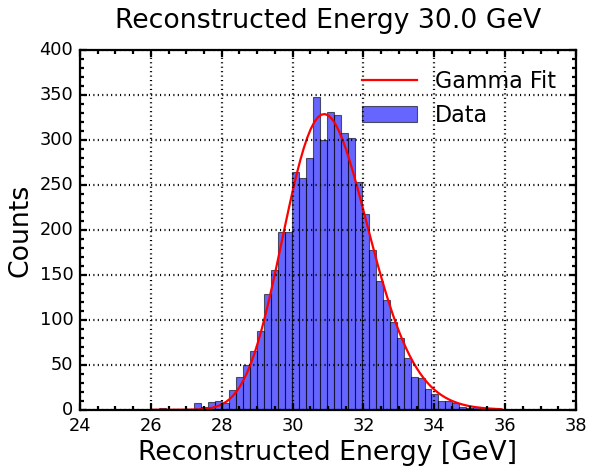

appending results for E = 30.0
Mean_Gamma: 31.080162884536563 Mean_Gamma_Error: 0.030278608066653098
Peak_Gamma: 30.89169744648965 Peak_Gamma_Error: 0.029975969106525713
Mean: 41.7620646660453, Peak: 41.63630676269531, RMS: 1.5861050850529501
Initial Gamma Fit Parameters: [np.float64(1532.220558166504), np.float64(4.818525330911279), np.float32(34.119377), np.float64(1.5861050850529501)]
Gamma Fit Bounds: lower [np.float64(15.32220558166504), np.float64(-0.5181474669088721), np.float32(2.4119377), np.float64(0.158610508505295)], 
 upper [np.float64(9193.323348999023), np.float64(48.18525330911279), np.float32(61.179066), np.float64(15.861050850529502)]
Gamma Fit Parameters: [1.53223689e+03 4.81852533e+01 3.08727940e+01 2.27068986e-01]
Gamma Fit Peak: 41.587101666102434 ± 0.03045944487780195, Mean: 41.814170652242 ± 0.030717154524181854, Resolution: 0.03790148619864187 ± 0.0005029640779441064


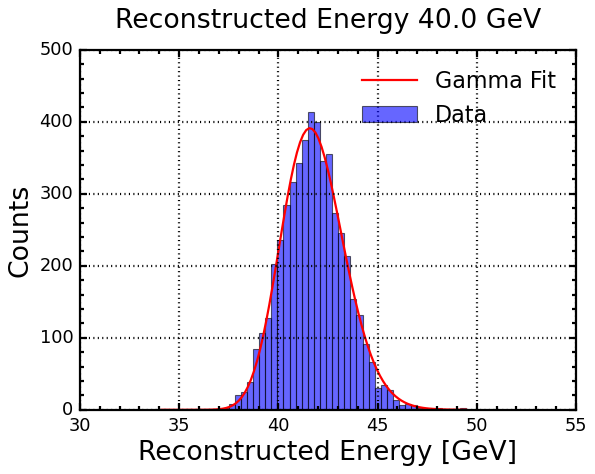

appending results for E = 40.0
Mean_Gamma: 41.814170652242 Mean_Gamma_Error: 0.030717154524181854
Peak_Gamma: 41.587101666102434 Peak_Gamma_Error: 0.03045944487780195
Mean: 52.76399503031897, Peak: 52.082008361816406, RMS: 1.7117408791514437
Initial Gamma Fit Parameters: [np.float64(1464.4985809326172), np.float64(3.7371055288949324), np.float32(46.36704), np.float64(1.7117408791514437)]
Gamma Fit Bounds: lower [np.float64(14.644985809326172), np.float64(-0.6262894471105067), np.float32(3.636704), np.float64(0.17117408791514438)], 
 upper [np.float64(8786.991485595703), np.float64(37.37105528894932), np.float32(79.55056), np.float64(17.117408791514436)]
Gamma Fit Parameters: [1.45968995e+03 3.73710553e+01 4.25141187e+01 2.76890526e-01]
Gamma Fit Peak: 52.58491936603732 ± 0.043505077984235245, Mean: 52.86180989187477 ± 0.043982103570566394, Resolution: 0.03218952473688366 ± 0.0005779720655343493


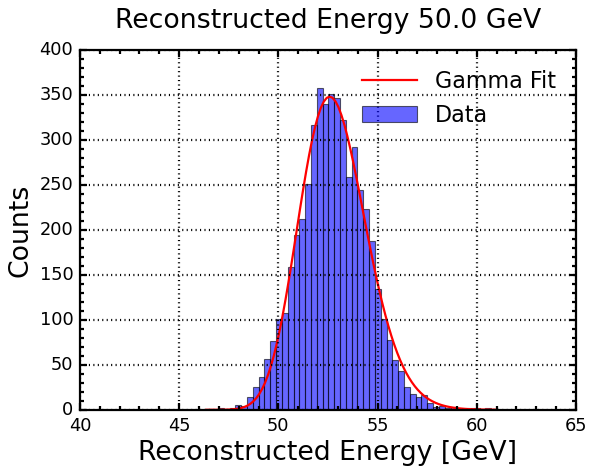

appending results for E = 50.0
Mean_Gamma: 52.86180989187477 Mean_Gamma_Error: 0.043982103570566394
Peak_Gamma: 52.58491936603732 Peak_Gamma_Error: 0.043505077984235245
Mean: 62.280956672309514, Peak: 61.860679626464844, RMS: 1.59470767775263
Initial Gamma Fit Parameters: [np.float64(1360.9233283996582), np.float64(3.765992779634365), np.float32(56.2753), np.float64(1.59470767775263)]
Gamma Fit Bounds: lower [np.float64(13.609233283996582), np.float64(-0.6234007220365635), np.float32(4.62753), np.float64(0.159470767775263)], 
 upper [np.float64(8165.539970397949), np.float64(37.65992779634365), np.float32(94.41295), np.float64(15.947076777526298)]
Gamma Fit Parameters: [1.36132791e+03 3.76599278e+01 5.25969893e+01 2.60333793e-01]
Gamma Fit Peak: 62.14080735796638 ± 0.04033724405309169, Mean: 62.40114115058868 ± 0.04077619097377864, Resolution: 0.02570948607945102 ± 0.00045203038796015784


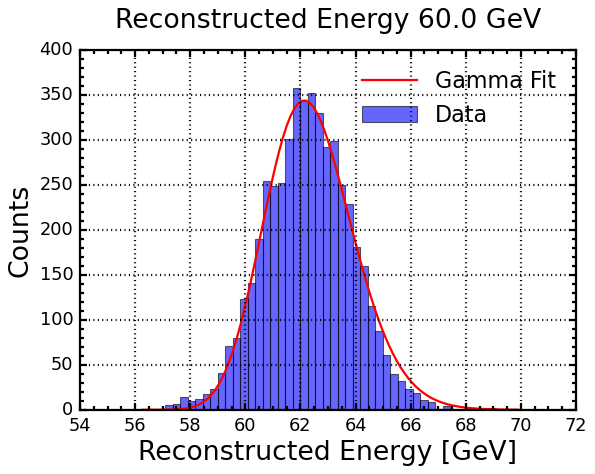

appending results for E = 60.0
Mean_Gamma: 62.40114115058868 Mean_Gamma_Error: 0.04077619097377864
Peak_Gamma: 62.14080735796638 Peak_Gamma_Error: 0.04033724405309169


In [ ]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error,
            "Best_Val_Loss": best_val_loss
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_DGCNN_{CONF_NAME}_Fit.csv")
print(f"Saving fit results to {outputfile_name}")
OutputCSV(Reco_hist_all[0], Energy_test, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")